# <center> Week 5 Session 3  - Image processing with Python and OpenCV

# Import libraries

In [1]:
from __future__ import print_function
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import requests

# scikit-image (a.k.a. skimage ) is a collection of algorithms for image processing and computer vision.
# io is image input output module
from skimage import io

random.seed(12345)

### Loading the image and checking if it is loaded without any problem

(187, 270, 3)


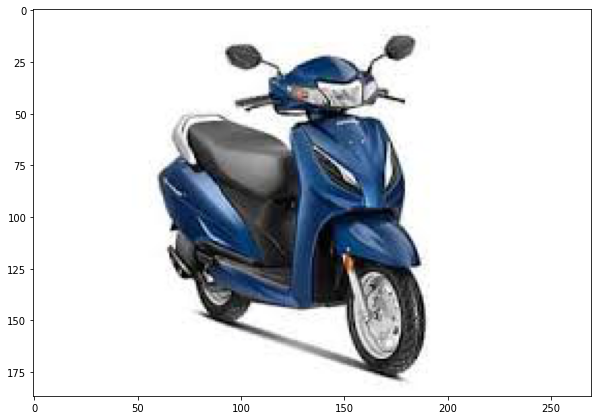

In [15]:
# io.imread return an image array for the provided image. Can extract image information from the links also.
# importing many images, you can choose which you like to process
# https://scikit-image.org/docs/dev/api/skimage.io.html#imread

#src = io.imread("https://media.istockphoto.com/photos/playing-cards-picture-id496913440?k=20&m=496913440&s=170667a&w=0&h=6AZI4Ch9_9sxFE0Zux_eIOlE3lKMi8HqIp05OECZwVs=")
src = io.imread("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcShID4pxKM2ZHzFtL5_1_UzmLRaLhVL9-GTHA&usqp=CAU")
#src = io.imread("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2rdSGhan5l9tyOmoMZOn5io5gMMxoPd146A&usqp=CAU")
#src = io.imread("https://m.media-amazon.com/images/I/71h6br16TlL._SL1100_.jpg")
#src = io.imread("https://c8.alamy.com/comp/2AENGEE/data-processing-cycle-2AENGEE.jpg")


print(src.shape)
plt.figure(figsize = (10,10))
plt.imshow(src)
plt.show()

### All the above images have white background. We will change the background from white to black, since that will help later to extract better results during the use of Distance Transform

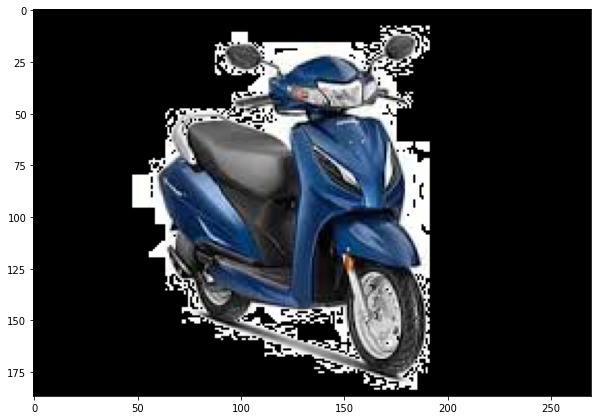

In [16]:
# changing pixel values from 255 to 0 to convert from white to black
src[np.all(src == 255, axis=2)] = 0

# Show output image
plt.figure(figsize = (10,10))
plt.imshow(src)
plt.show()

### Afterwards we will sharpen our image in order to acute the edges of the foreground objects. We will apply a laplacian filter with a quite strong filter (an approximation of second derivative)

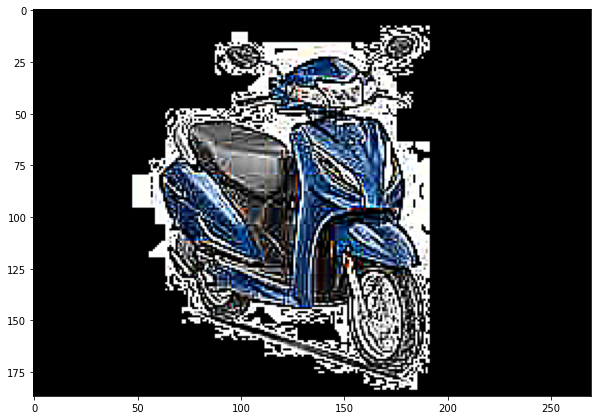

In [25]:
# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, quite a strong kernel
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)

# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated

# https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04
imgLaplacian = cv2.filter2D(src, cv2.CV_32F, kernel)
sharp = np.float32(src)
imgResult = sharp - imgLaplacian

# convert back to 8bits gray scale
# https://numpy.org/doc/stable/reference/generated/numpy.clip.html
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

#cv.imshow('Laplace Filtered Image', imgLaplacian)
plt.figure(figsize = (10,10))
plt.imshow(imgResult)
plt.show()

### Now we transform our new sharpened source image to a grayscale and a binary one, respectively

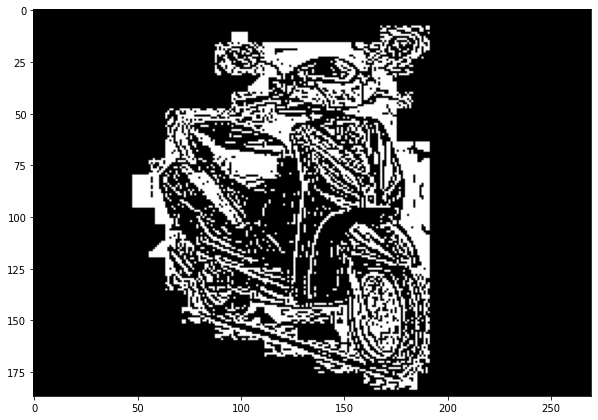

In [26]:
# Creating binary image from source image
# https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab
bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)

# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
_, bw = cv2.threshold(bw, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.figure(figsize = (10,10))
plt.imshow(bw, cmap = 'gray')
plt.show()

### We are ready now to apply the Distance Transform on the binary image. Moreover, we normalize the output image in order to be able visualize and threshold the result

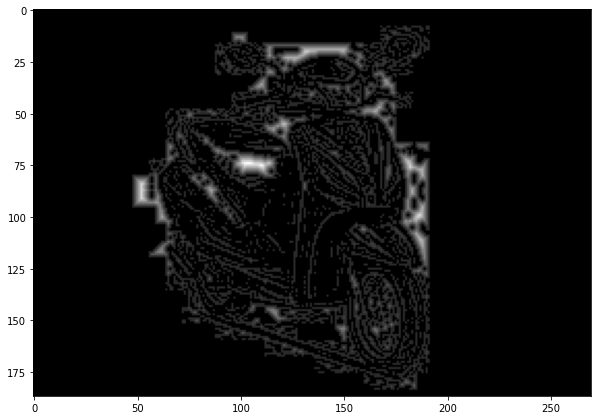

In [27]:
# Perform the distance transform algorithm
# https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)

# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
# https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga7bcf47a1df78cf575162e0aed44960cb
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.figure(figsize = (10,10))
plt.imshow(dist, cmap = 'gray')
plt.show()

### We threshold the dist image and then perform some morphology operation (i.e. dilation) in order to extract the peaks from the above image

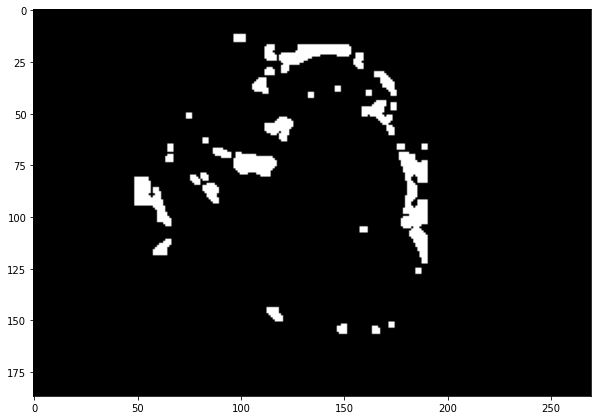

In [28]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)

# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)

plt.figure(figsize = (10,10))
plt.imshow(dist, cmap = 'gray')
plt.show()

### From each blob then we create a seed/marker for the watershed algorithm with the help of the cv::findContours function

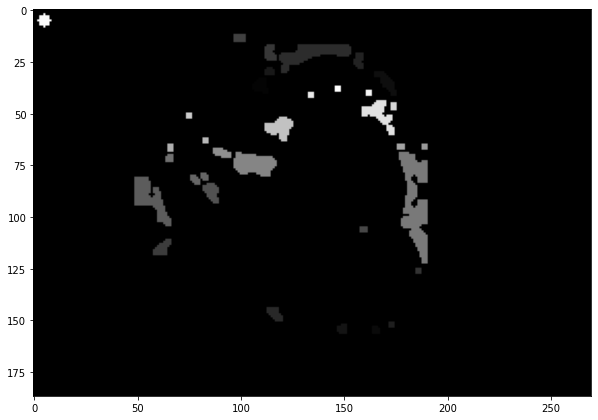

In [29]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')

# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)

# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)

# Draw the background marker
cv2.circle(markers, (5,5), 3, (255, 255, 255), -1)

markers_8u = (markers * 10).astype('uint8')

plt.figure(figsize = (10,10))
plt.imshow(markers_8u, cmap = 'gray')
plt.show()

### Finally, we can apply the watershed algorithm, and visualize the result

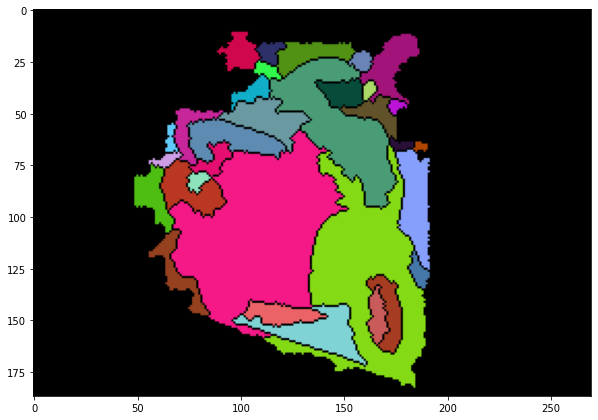

In [30]:
# Perform the watershed algorithm
cv2.watershed(imgResult, markers)

# mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)

# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)

# Generate random colors
colors = []
for contour in contours:
    colors.append((random.randint(0,256), random.randint(0,256), random.randint(0,256)))

# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)

# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

# Visualize the final image
plt.figure(figsize = (10,10))
plt.imshow(dst)
plt.show()

## In the next session - 
## We will understand the Image Segmentation in depth, and get the Introduction to UNet Architecture for Semantic Segmentation for our project